In [0]:
import numpy as np
import pandas as pd
import os
import json
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [3]:
os.getcwd()

'/content'

In [0]:
def in_washington(loc):
  loc = re.split(', | ', loc.lower())
  return (("washington" in loc) or ('wa' in loc)) and not (("d.c." in loc) or ("dc" in loc))

def in_massachusetts(loc):
  loc = re.split(', | ', loc.lower())
  return (("massachusetts" in loc) or ('ma' in loc))

In [0]:
tweet_text = []
tweet_labels = []
with open('./tweets_#superbowl.txt', 'r') as json_file:  
    for line in json_file:
      data = json.loads(line)
      if in_massachusetts(data['tweet']['user']['location']):
        tweet_text.append(data['tweet']['text'])
        tweet_labels.append(0)
      if in_washington(data['tweet']['user']['location']):
        tweet_text.append(data['tweet']['text'])
        tweet_labels.append(1)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/christian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/christian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
stop_words = text.ENGLISH_STOP_WORDS
wnl = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

In [0]:
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. Taken from discussion slides"""
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
      
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]
  
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in stop_words and not word.isdigit())

In [0]:
vectorizer = CountVectorizer(stop_words='english', min_df=3, analyzer=stem_rmv_punc)

In [0]:
print(len(tweet_text))
print(len(tweet_labels))

27911
27911


In [0]:
print(tweet_text[:2])
print(tweet_labels[:2])

[u'Our @ButchStearns talked #Patriots w/3X #SuperBowl champ Matt Light Full interview @ 10 http://t.co/6s9XqUUcyj #FOX25 http://t.co/iTAFnwQc2G', u'Interview With the Seattle Seahawks Superbowl Champions http://t.co/4HS6DYeOxV #Gohawks #superbowlxlviii #NFL #ESPN']
[0, 1]


In [0]:
vec_train_mat = vectorizer.fit_transform(tweet_text)

In [0]:
print(vec_train_mat.shape)

(27911, 5600)


In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [0]:
vec_tfidf_train = tfidf_transformer.fit_transform(vec_train_mat)

In [0]:
from sklearn.decomposition import TruncatedSVD

In [0]:
lsi = TruncatedSVD(n_components=100)
lsi_train_matrix = lsi.fit_transform(vec_tfidf_train)
print(lsi_train_matrix.shape)

(27911, 100)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
tweet_labels = np.array(tweet_labels)
X_train, X_test, y_train, y_test = train_test_split(lsi_train_matrix, tweet_labels, test_size=0.1, random_state=42)

In [0]:
#Plot the ROC curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
#confusion matrix

#This function prints and plots the confusion matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  #normalize can be applied by setting normalize = true
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot(pipe, train_data, train_label, test_data, test_label):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(train_dataset)

    if hasattr(pipe, 'decision_function'):
      prob_score = pipe.decision_function(test_data)
      fpr, tpr, thresholds = roc_curve(test_label, prob_score)
    else:
      prob_score = pipe.predict_proba(test_data)
      fpr, tpr, thresholds = roc_curve(test_label, prob_score[:,1])
    
    test_pred = pipe.predict(test_data)
    
    #plot roc curve
    plot_roc(fpr, tpr)
    
    #get scores
    accuracy = accuracy_score(test_label, test_pred)
    recall = recall_score(test_label, test_pred)
    precision = precision_score(test_label, test_pred)
    f1 = f1_score(test_label, test_pred)
    
    print('Accuracy = ', accuracy)
    print('Recall = ', recall)
    print('Precision = ', precision)
    print('F-1 Score = ', f1)
    
    #report the confusion matrix
    class_names = ['Massachusetts', 'Washington']
    cnf_matrix = confusion_matrix(test_label, test_pred)
    np.set_printoptions(precision=2)
    
    #plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                         title = 'Confusion Matrix (without normalization)')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = True,
                         title = 'Confusion Matrix (normalization)')
    
    plt.show()
    #return pipe

In [0]:
from sklearn.svm import LinearSVC
svm = LinearSVC(C=100, random_state=42)

('Accuracy = ', 0.7704154727793696)
('Recall = ', 0.5913497390007457)
('Precision = ', 0.8950338600451467)
('F-1 Score = ', 0.712168837000449)
Confusion matrix, without normalization
[[1358   93]
 [ 548  793]]
Normalized confusion matrix
[[0.94 0.06]
 [0.41 0.59]]


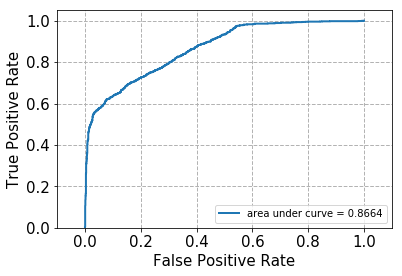

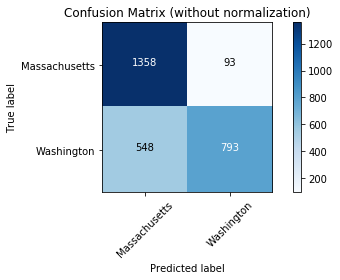

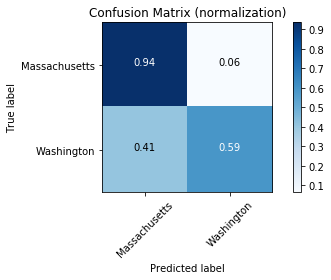

In [0]:
fit_predict_and_plot(svm, X_train, y_train, X_test, y_test)

In [0]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(random_state=42)

/usr/local/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


('Accuracy = ', 0.7729226361031518)
('Recall = ', 0.7084265473527218)
('Precision = ', 0.7963118189438391)
('F-1 Score = ', 0.749802683504341)
Confusion matrix, without normalization
[[1208  243]
 [ 391  950]]
Normalized confusion matrix
[[0.83 0.17]
 [0.29 0.71]]


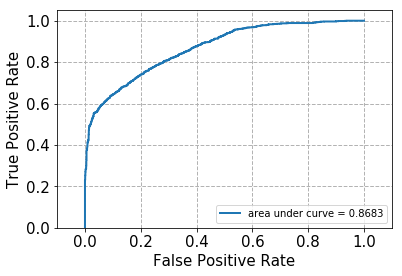

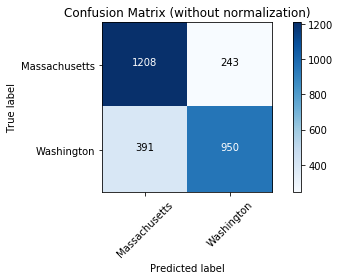

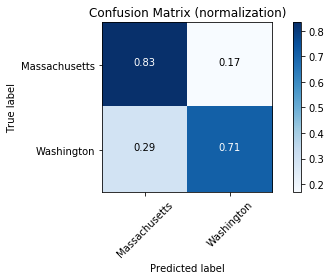

In [0]:
fit_predict_and_plot(nn, X_train, y_train, X_test, y_test)

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

/usr/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


('Accuracy = ', 0.7614613180515759)
('Recall = ', 0.6539895600298284)
('Precision = ', 0.8127896200185357)
('F-1 Score = ', 0.724793388429752)
Confusion matrix, without normalization
[[1249  202]
 [ 464  877]]
Normalized confusion matrix
[[0.86 0.14]
 [0.35 0.65]]


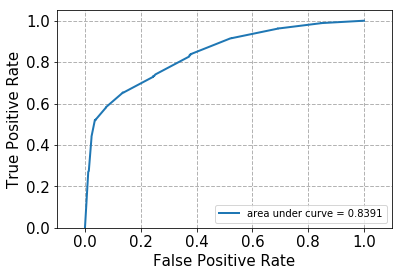

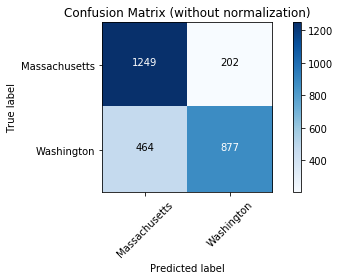

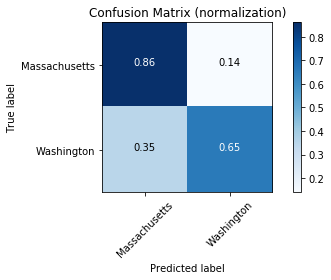

In [0]:
fit_predict_and_plot(rf, X_train, y_train, X_test, y_test)

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sid = SIA()
was_s = []
was_t = []
mat_s = []
mat_t = []
with open('./tweets_#superbowl.txt', 'r') as json_file:  
    for line in json_file:
      data = json.loads(line)
      if in_washington(data['tweet']['user']['location']):
        score = sid.polarity_scores(data["tweet"]["text"])
        if np.abs(score["compound"]) > 0.01:
          try:
            s = score["compound"]
            t = data['tweet']["timestamp_ms"]
            was_s.append(s)
            was_t.append(t)
          except:
            pass
      if in_massachusetts(data['tweet']['user']['location']):
        score = sid.polarity_scores(data["tweet"]["text"])
        if np.abs(score["compound"]) > 0.01:
          try:
            s = score["compound"]
            t = data['tweet']["timestamp_ms"]
            mat_s.append(s)
            mat_t.append(t)
          except:
            pass
      

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/christian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [0]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate((ret[:n - 1]/np.arange(1,n),ret[n - 1:] / n))

In [0]:
def interpolate(x,y,y_range):
  vals=[]
  i = 1
  for z in y_range:
    while y[i] < z:
      i+=1
    vals.append(x[i-1]+(x[i]-x[i-1])*(1.0*z-y[i-1])/(y[i]-y[i-1]))
  return vals
      

In [0]:
was_t = np.array(map(int, was_t))
mat_t = np.array(map(int, mat_t))

In [0]:
was_s_smooth = moving_average(was_s,n=200)
mat_s_smooth = moving_average(mat_s,n=200)


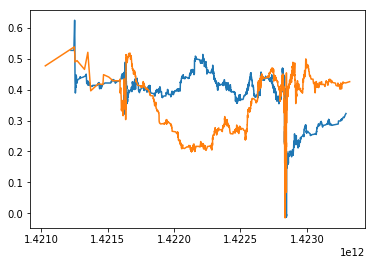

In [0]:
plt.plot(was_t,was_s_smooth)
plt.plot(mat_t,mat_s_smooth)
plt.show()


In [0]:
y_range = np.arange(was_t[0],was_t[-1],10000)
was_s_inter = interpolate(was_s_smooth,was_t,y_range)
mat_s_inter = interpolate(mat_s_smooth,mat_t,y_range)

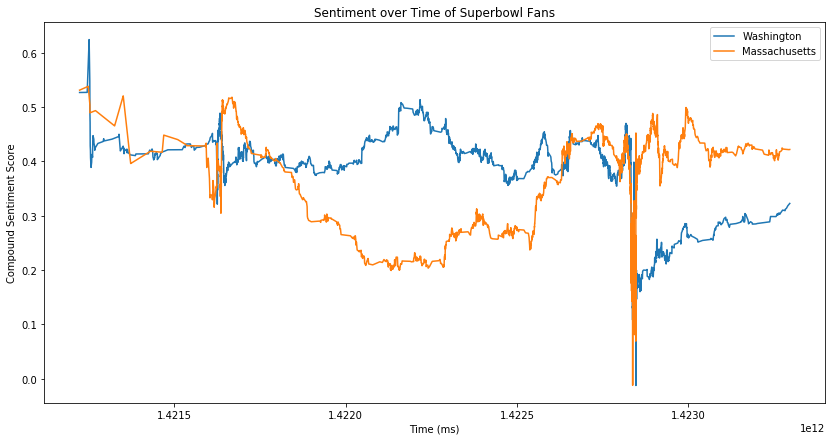

In [0]:
plt.figure(figsize=(14,7))
plt.plot(y_range,was_s_inter,label='Washington')
plt.plot(y_range,mat_s_inter,label='Massachusetts')
plt.xlabel("Time (ms)")
plt.ylabel("Compound Sentiment Score")
plt.title("Sentiment over Time of Superbowl Fans")
plt.legend()
plt.show()

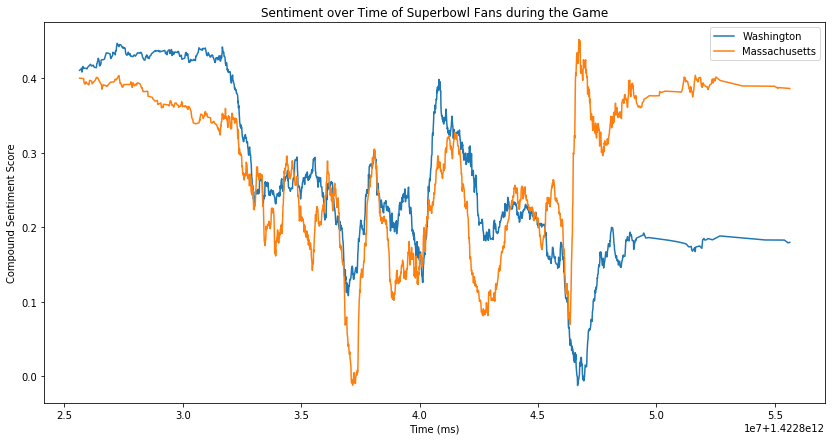

In [0]:
plt.figure(figsize=(14,7))
plt.plot(y_range[-47000:-44000],was_s_inter[-47000:-44000],label='Washington')
plt.plot(y_range[-47000:-44000],mat_s_inter[-47000:-44000],label='Massachusetts')
plt.xlabel("Time (ms)")
plt.ylabel("Compound Sentiment Score")
plt.title("Sentiment over Time of Superbowl Fans during the Game")
plt.legend()
plt.show()

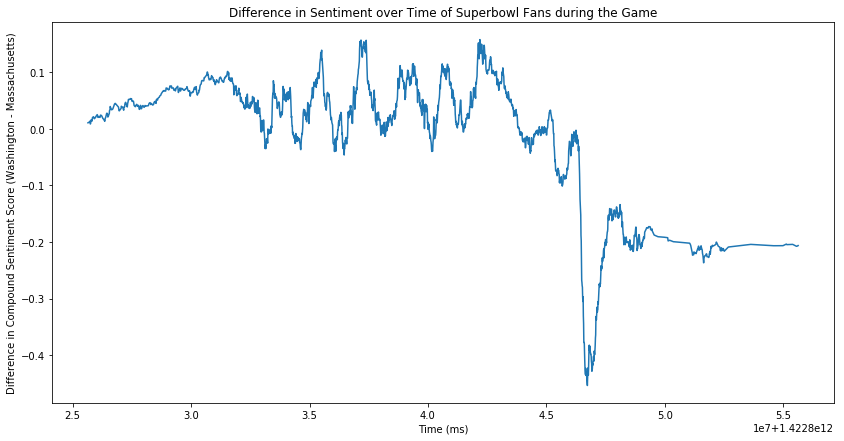

In [0]:
plt.figure(figsize=(14,7))
plt.plot(y_range[-47000:-44000],np.array(was_s_inter[-47000:-44000])-np.array(mat_s_inter[-47000:-44000]))
plt.xlabel("Time (ms)")
plt.ylabel("Difference in Compound Sentiment Score (Washington - Massachusetts)")
plt.title("Difference in Sentiment over Time of Superbowl Fans during the Game")
plt.show()